In [40]:
import pandas as pd
import geopandas as gpd
import glob
import matplotlib.pyplot as plt


In [2]:
property_df = pd.read_parquet('../../data/raw/property_details.parquet')

In [3]:
# Drop rows where price = None (Sometimes not given on website)
property_df = property_df[property_df['price'].notnull()]

# Drop nbn_details, property_features columns (often left empty on website)
property_df = property_df.drop(columns=['nbn_details', 'property_features'])

In [4]:
# View rows with None values
property_df[property_df.isnull().any(axis=1)]

,title,description,street_address,suburb,postcode,price,bedrooms,bathrooms,parking,primary_property_type,structured_features,video_count,photo_count,date_listed,days_listed,floor_plans_count,virtual_tour,nearby_schools


In [5]:
property_df.head()

,title,description,street_address,suburb,postcode,price,bedrooms,bathrooms,parking,primary_property_type,structured_features,video_count,photo_count,date_listed,days_listed,floor_plans_count,virtual_tour,nearby_schools
0,"60 Little Windrock Lane, Craigieburn VIC 3064 ...","View this 2 bedroom, 1 bathroom rental house a...","60 Little Windrock Lane, Craigieburn VIC 3064",Craigieburn,3064,$450 Per Week,2.0,1.0,1.0,House,"[{'category': 'Indoor', 'name': 'Built in ward...",0.0,21.0,2024-08-22T16:07:26.000,14.0,0.0,False,"[{'address': 'Craigieburn, VIC 3064', 'distanc..."
1,"53 Were Street, Brighton VIC 3186 - House For ...","View this $1,500/week 4 bedroom, 2 bathroom re...","53 Were Street, Brighton VIC 3186",Brighton,3186,"$1,490.00",4.0,2.0,2.0,House,[],0.0,6.0,2024-06-02T18:11:41.000,95.0,2.0,True,"[{'address': 'Brighton, VIC 3186', 'distance':..."
2,"43 Tackle Drive, Point Cook VIC 3030 - Townhou...","View this 3 bedroom, 2 bathroom rental townhou...","43 Tackle Drive, Point Cook VIC 3030",Point Cook,3030,$550 per Week,3.0,2.0,2.0,Townhouse/Villa,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,17.0,2024-09-03T12:01:18.000,2.0,0.0,True,"[{'address': 'Point Cook, VIC 3030', 'distance..."
3,"3 Rostrevor Parade, Mont Albert VIC 3127 - Hou...","View this 5 bedroom, 2 bathroom rental house a...","3 Rostrevor Parade, Mont Albert VIC 3127",Mont Albert,3127,$800 weekly,5.0,2.0,2.0,House,[],0.0,8.0,2024-07-01T12:53:48.000,66.0,0.0,False,"[{'address': 'Mont Albert, VIC 3127', 'distanc..."
4,"48 Roberts Street, Frankston VIC 3199 - Studio...","View this 9 bedroom, 3 bathroom rental studio ...","48 Roberts Street, Frankston VIC 3199",Frankston,3199,$299 per week,9.0,3.0,4.0,Apartment,"[{'category': 'Indoor', 'name': 'Furnished', '...",0.0,20.0,2024-07-02T11:24:10.000,65.0,1.0,False,"[{'address': 'Frankston, VIC 3199', 'distance'..."


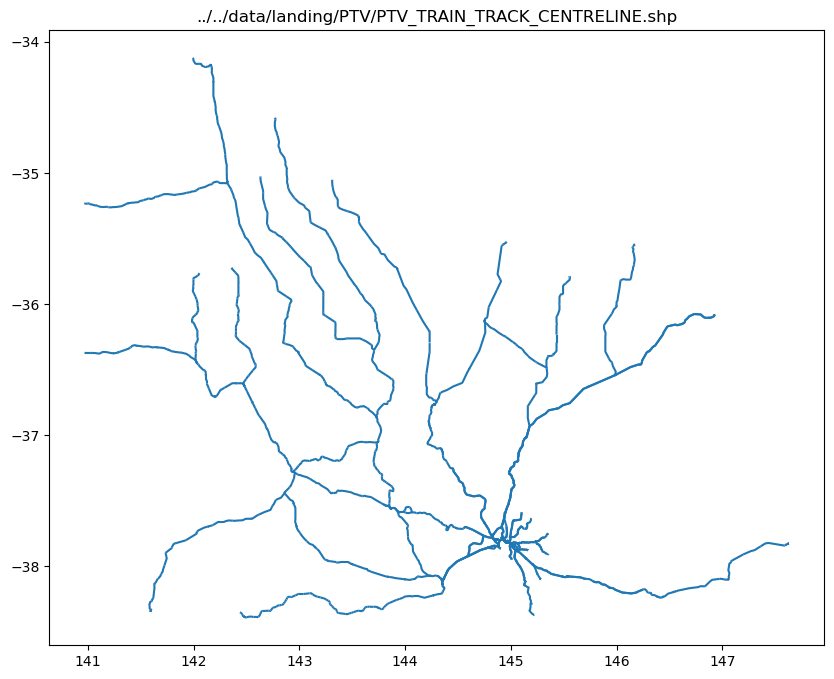

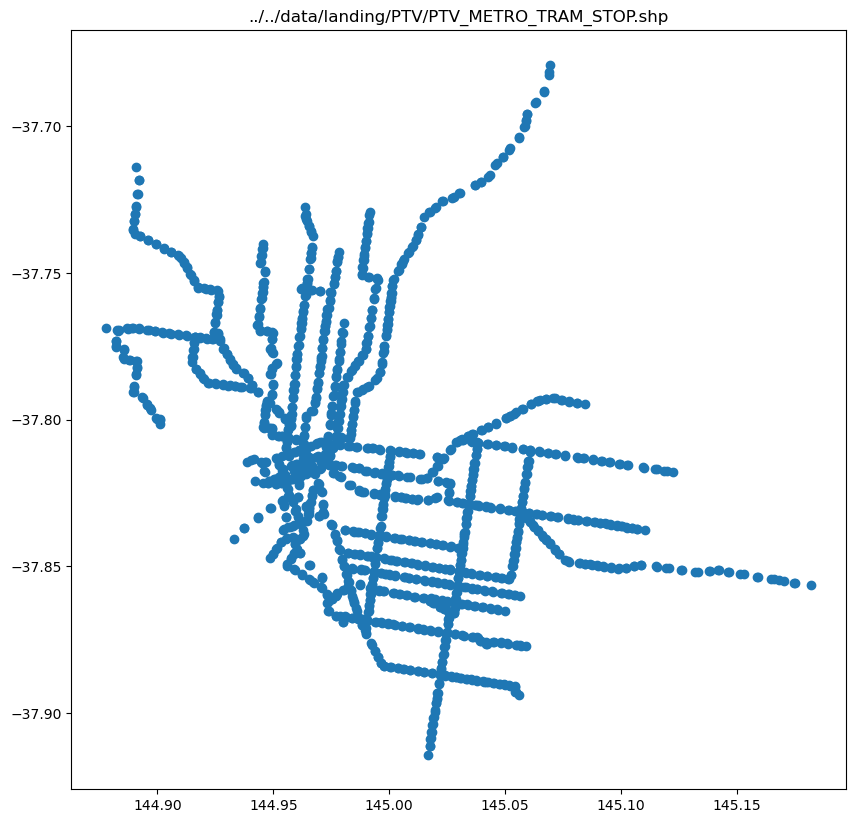

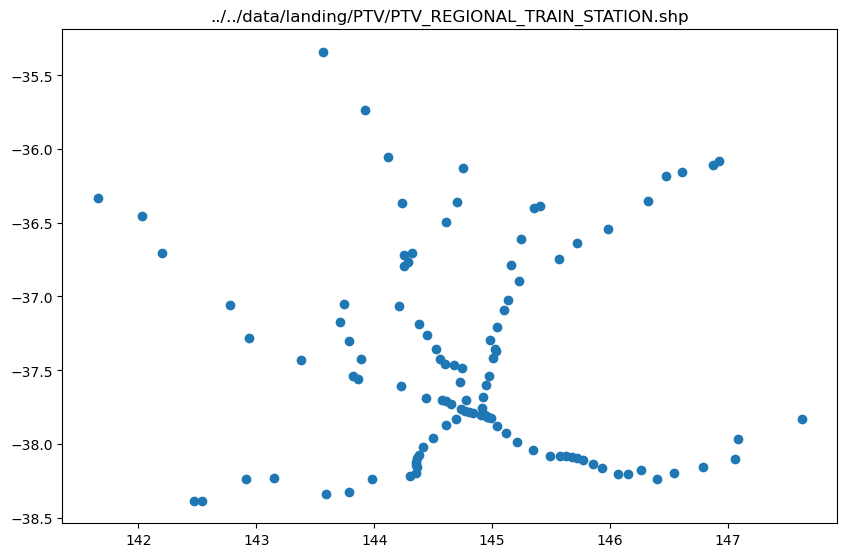

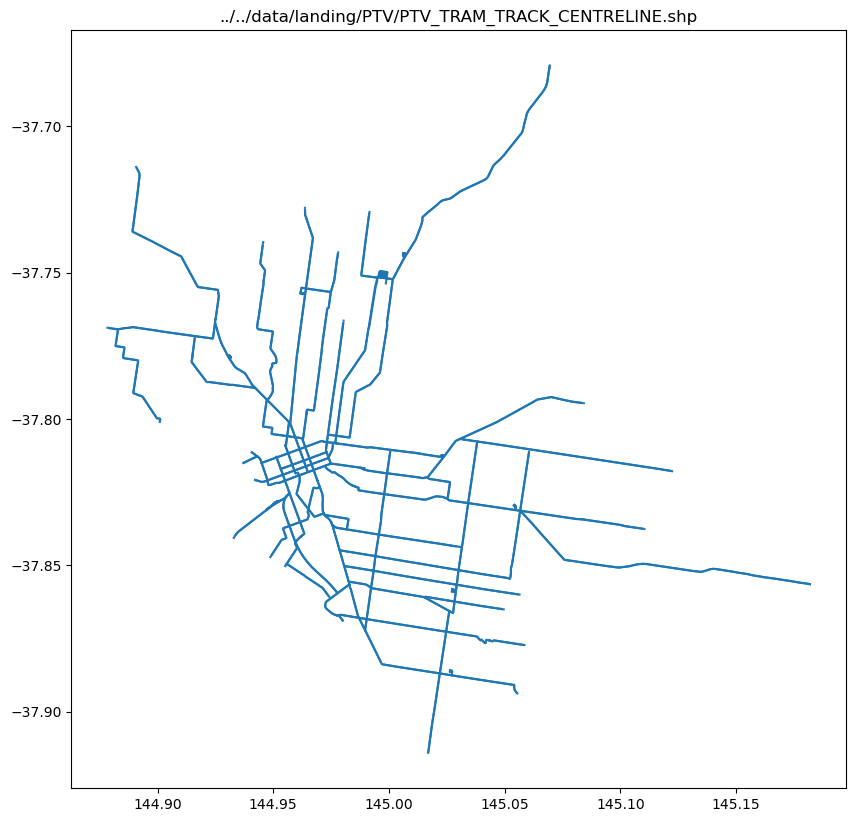

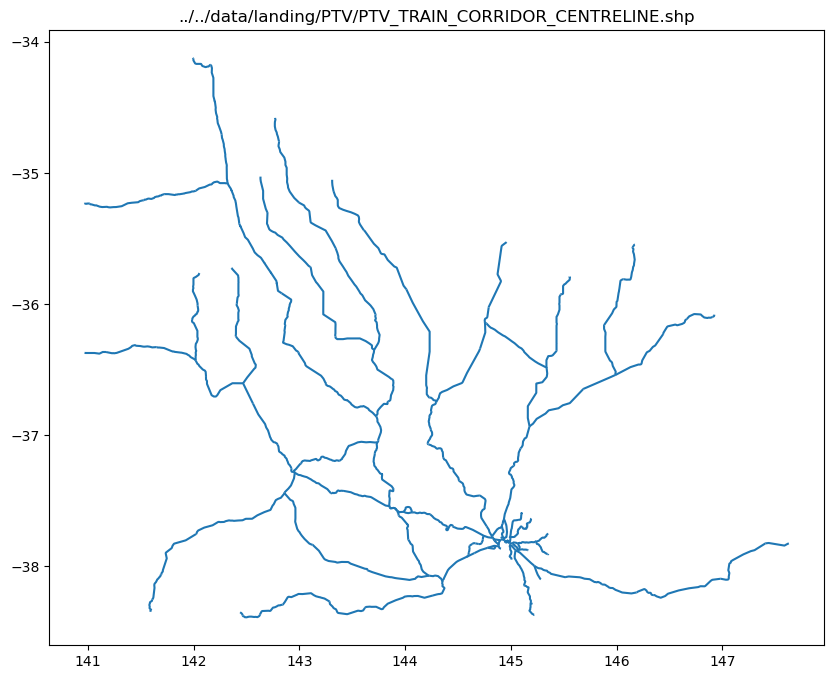

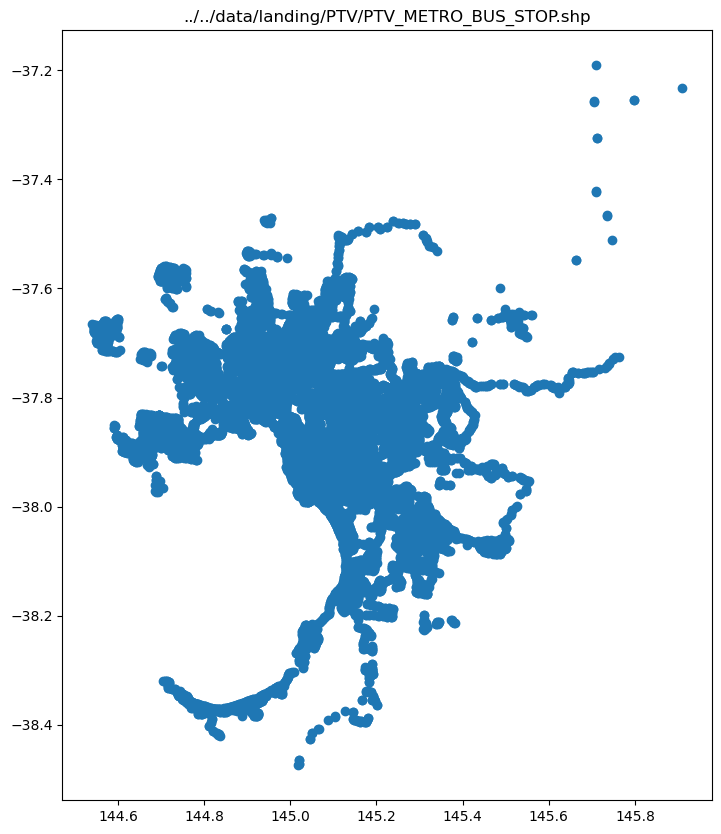

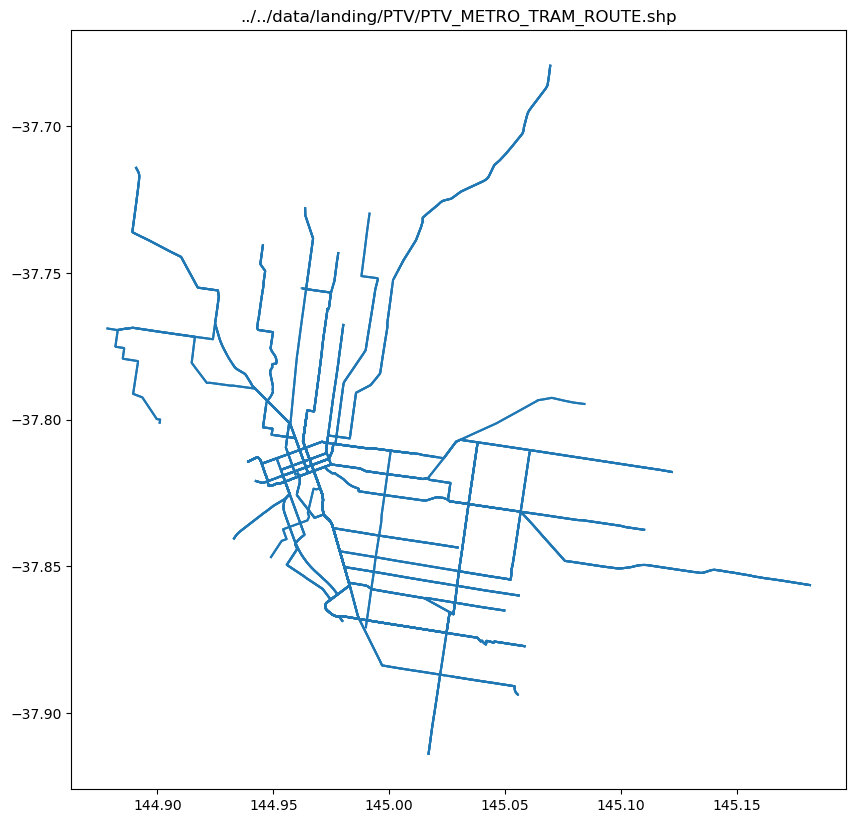

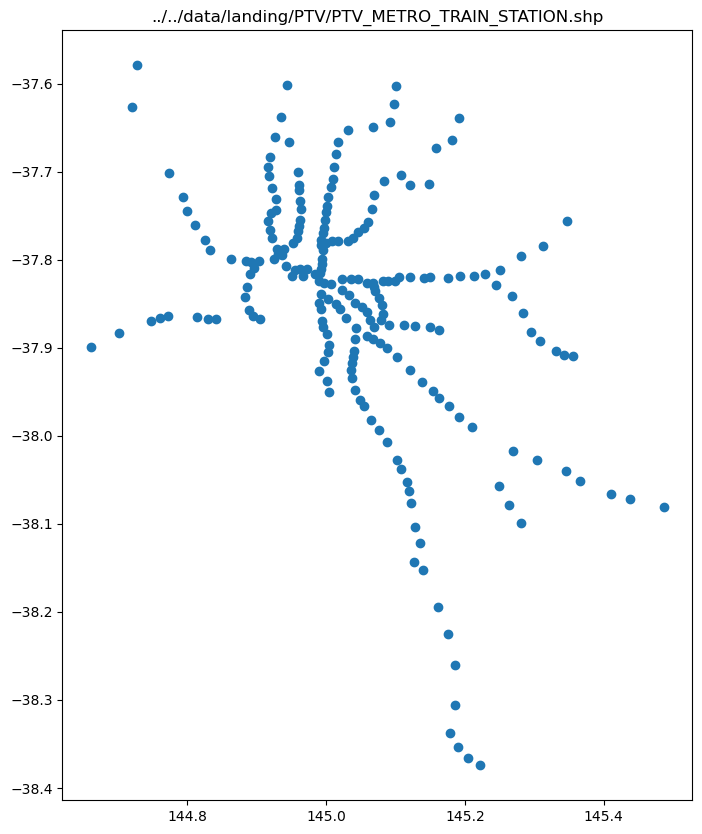

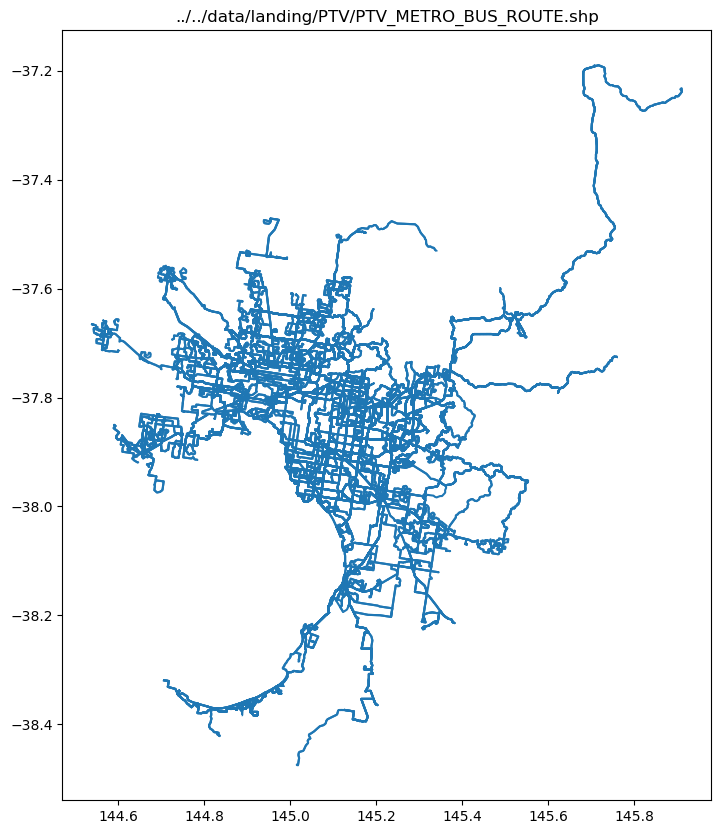

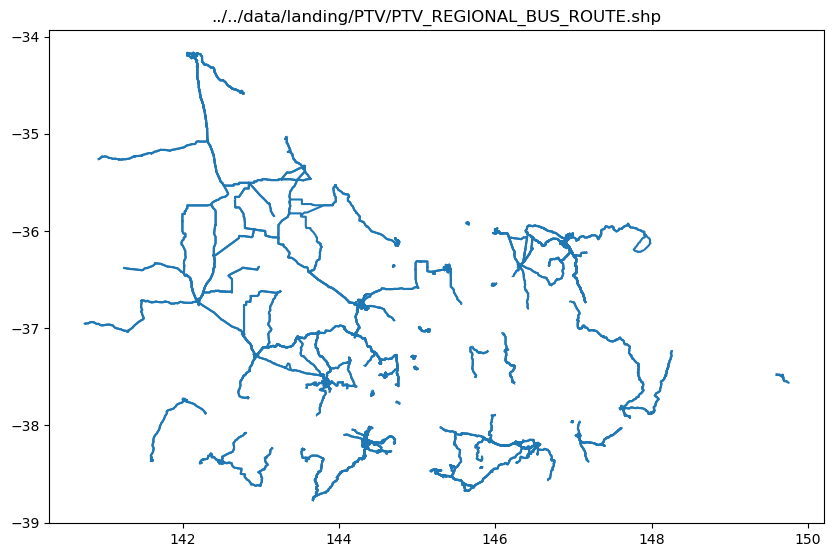

In [45]:
# Step 1: Get all shapefiles in a folder
shapefiles = glob.glob("../../data/landing/PTV/*.shp")

for shp in shapefiles:
    gdf = gpd.read_file(shp)

    # Step 4: Plot each shapefile separately with the filename as the title
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax)
    ax.set_title(shp)  # Set the filename as the title

    # Display the plot
    plt.show()

In [46]:
pdf = property_df.sample(100)

pdf

,title,description,street_address,suburb,postcode,price,bedrooms,bathrooms,parking,primary_property_type,structured_features,video_count,photo_count,date_listed,days_listed,floor_plans_count,virtual_tour,nearby_schools
8218,"2657/181 Exhibition Street, Melbourne VIC 3000...","View this 1 bedroom, 1 bathroom rental apartme...","2657/181 Exhibition Street, Melbourne VIC 3000",Melbourne,3000,$65 PER WEEK | $282 P.C.M,1.0,1.0,1.0,Apartment,[],0.0,1.0,2024-08-21T09:44:28.000,16.0,0.0,False,"[{'address': 'Melbourne, VIC 3000', 'distance'..."
8857,"10B Boonah Street, Springvale VIC 3171 - Apart...","View this 1 bedroom, 1 bathroom rental apartme...","10B Boonah Street, Springvale VIC 3171",Springvale,3171,"$370 pw / $1,608 pcm",1.0,1.0,1.0,Apartment,"[{'category': 'Indoor', 'name': 'Gas', 'source...",1.0,16.0,2024-09-05T16:28:27.000,0.0,0.0,False,"[{'address': 'Springvale, VIC 3171', 'distance..."
2372,"451A Upper Murray Rd, Towong Upper VIC 3707 - ...","View this 1 bedroom, 1 bathroom rental apartme...","451A Upper Murray Rd, Towong Upper VIC 3707",Towong Upper,3707,$300 per week,1.0,1.0,1.0,Apartment,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,5.0,2024-05-16T14:08:07.000,112.0,0.0,False,"[{'address': 'Corryong, VIC 3707', 'distance':..."
13773,"2 Morses Court Tawonga South, Tawonga South VI...","View this 3 bedroom, 2 bathroom rental house a...","2 Morses Court Tawonga South, Tawonga South VI...",Tawonga South,3698,$485,3.0,2.0,2.0,House,"[{'category': 'Indoor', 'name': 'Gas', 'source...",0.0,9.0,2024-08-28T15:09:46.000,8.0,0.0,False,"[{'address': 'Mount Beauty, VIC 3699', 'distan..."
11090,"1/531 Springvale Road, Glen Waverley VIC 3150 ...","View this $850/week 3 bedroom, 2 bathroom rent...","1/531 Springvale Road, Glen Waverley VIC 3150",Glen Waverley,3150,$850.00,3.0,2.0,2.0,Apartment,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,5.0,2024-08-30T11:45:41.000,6.0,1.0,False,"[{'address': 'Glen Waverley, VIC 3150', 'dista..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14039,"4 Tellin Lane, Point Lonsdale VIC 3225 - House...","View this 2 bedroom, 2 bathroom rental house a...","4 Tellin Lane, Point Lonsdale VIC 3225",Point Lonsdale,3225,$600 weekly,2.0,2.0,2.0,House,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,8.0,2024-08-16T15:31:19.000,20.0,0.0,False,"[{'address': 'Point Lonsdale, VIC 3225', 'dist..."
4149,"10/15 Addis Street, Geelong West VIC 3218 - Ap...","View this $350/week 1 bedroom, 1 bathroom rent...","10/15 Addis Street, Geelong West VIC 3218",Geelong West,3218,$350.00,1.0,1.0,1.0,Apartment,"[{'category': 'Indoor', 'name': 'Internal Laun...",0.0,11.0,2024-01-24T11:01:43.000,225.0,0.0,False,"[{'address': 'Newtown, VIC 3220', 'distance': ..."
4595,"61 Clarendon Street, Thornbury VIC 3071 - Hous...","View this 2 bedroom, 1 bathroom rental house a...","61 Clarendon Street, Thornbury VIC 3071",Thornbury,3071,$710 PW / $3085 PCM,2.0,1.0,1.0,House,"[{'category': 'Indoor', 'name': 'Built in ward...",0.0,6.0,2024-08-30T08:40:25.000,7.0,0.0,False,"[{'address': 'Thornbury, VIC 3071', 'distance'..."
3199,"314/406 La Trobe St, Melbourne VIC 3000 - Stud...","View this 1 bedroom, 1 bathroom rental studio ...","314/406 La Trobe St, Melbourne VIC 3000",Melbourne,3000,$420 weekly,1.0,1.0,0.0,Apartment,"[{'category': 'Indoor', 'name': 'Internal Laun...",0.0,6.0,2024-08-28T16:30:56.000,8.0,0.0,False,"[{'address': 'Melbourne, VIC 3000', 'distance'..."


In [49]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

# Initialize the geolocator
geolocator = Nominatim(user_agent="property_geocoder")

# Function to get longitude and latitude
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except Exception as e:
        print(f"Error getting coordinates for {address}: {e}")
        return (None, None)

# Apply the function to the 'street_address' column and store the results in new columns
pdf[['latitude', 'longitude']] = pdf['street_address'].apply(lambda x: pd.Series(get_coordinates(x)))

# Show the updated dataframe with coordinates
print(pdf[['street_address', 'latitude', 'longitude']])

# You can also save the updated dataframe if necessary
# property_df.to_csv("updated_property_with_coordinates.csv", index=False)


Error getting coordinates for 9/4 Little Buckingham St, Richmond VIC 3121: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=9%2F4+Little+Buckingham+St%2C+Richmond+VIC+3121&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error getting coordinates for 4 Marshall Way, Glen Waverley VIC 3150: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=4+Marshall+Way%2C+Glen+Waverley+VIC+3150&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error getting coordinates for 13/49 Adams Street, South Yarra VIC 3141: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=13%2F49+Adams+Street%2C+South+Yarra+VIC+3141&format=json&limit=1 (

In [52]:
pdf.dropna(inplace=True)

pdf

,title,description,street_address,suburb,postcode,price,bedrooms,bathrooms,parking,primary_property_type,structured_features,video_count,photo_count,date_listed,days_listed,floor_plans_count,virtual_tour,nearby_schools,latitude,longitude
8857,"10B Boonah Street, Springvale VIC 3171 - Apart...","View this 1 bedroom, 1 bathroom rental apartme...","10B Boonah Street, Springvale VIC 3171",Springvale,3171,"$370 pw / $1,608 pcm",1.0,1.0,1.0,Apartment,"[{'category': 'Indoor', 'name': 'Gas', 'source...",1.0,16.0,2024-09-05T16:28:27.000,0.0,0.0,False,"[{'address': 'Springvale, VIC 3171', 'distance...",-37.956345,145.150245
2372,"451A Upper Murray Rd, Towong Upper VIC 3707 - ...","View this 1 bedroom, 1 bathroom rental apartme...","451A Upper Murray Rd, Towong Upper VIC 3707",Towong Upper,3707,$300 per week,1.0,1.0,1.0,Apartment,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,5.0,2024-05-16T14:08:07.000,112.0,0.0,False,"[{'address': 'Corryong, VIC 3707', 'distance':...",-36.234710,148.031997
13773,"2 Morses Court Tawonga South, Tawonga South VI...","View this 3 bedroom, 2 bathroom rental house a...","2 Morses Court Tawonga South, Tawonga South VI...",Tawonga South,3698,$485,3.0,2.0,2.0,House,"[{'category': 'Indoor', 'name': 'Gas', 'source...",0.0,9.0,2024-08-28T15:09:46.000,8.0,0.0,False,"[{'address': 'Mount Beauty, VIC 3699', 'distan...",-36.733034,147.150426
11090,"1/531 Springvale Road, Glen Waverley VIC 3150 ...","View this $850/week 3 bedroom, 2 bathroom rent...","1/531 Springvale Road, Glen Waverley VIC 3150",Glen Waverley,3150,$850.00,3.0,2.0,2.0,Apartment,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,5.0,2024-08-30T11:45:41.000,6.0,1.0,False,"[{'address': 'Glen Waverley, VIC 3150', 'dista...",-37.902081,145.161406
2093,"3/37 Koonawarra Street, Clayton VIC 3168 - Apa...","View this 3 bedroom, 2 bathroom rental apartme...","3/37 Koonawarra Street, Clayton VIC 3168",Clayton,3168,$700/week,3.0,2.0,1.0,Apartment,"[{'category': 'Indoor', 'name': 'Heating', 'so...",0.0,11.0,2024-09-02T15:06:46.000,3.0,0.0,False,"[{'address': 'Clayton, VIC 3168', 'distance': ...",-37.906965,145.125361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,"10/300 Young Street, Fitzroy VIC 3065 - Apartm...","View this 2 bedroom, 1 bathroom rental apartme...","10/300 Young Street, Fitzroy VIC 3065",Fitzroy,3065,$645 per week,2.0,1.0,1.0,Apartment,"[{'category': 'Indoor', 'name': 'Internal Laun...",0.0,9.0,2024-08-22T11:47:40.000,14.0,1.0,False,"[{'address': 'Fitzroy, VIC 3065', 'distance': ...",-37.807663,144.978060
14039,"4 Tellin Lane, Point Lonsdale VIC 3225 - House...","View this 2 bedroom, 2 bathroom rental house a...","4 Tellin Lane, Point Lonsdale VIC 3225",Point Lonsdale,3225,$600 weekly,2.0,2.0,2.0,House,"[{'category': 'Outdoor', 'name': 'Secure Parki...",0.0,8.0,2024-08-16T15:31:19.000,20.0,0.0,False,"[{'address': 'Point Lonsdale, VIC 3225', 'dist...",-38.267681,144.608767
4149,"10/15 Addis Street, Geelong West VIC 3218 - Ap...","View this $350/week 1 bedroom, 1 bathroom rent...","10/15 Addis Street, Geelong West VIC 3218",Geelong West,3218,$350.00,1.0,1.0,1.0,Apartment,"[{'category': 'Indoor', 'name': 'Internal Laun...",0.0,11.0,2024-01-24T11:01:43.000,225.0,0.0,False,"[{'address': 'Newtown, VIC 3220', 'distance': ...",-38.144577,144.337187
4595,"61 Clarendon Street, Thornbury VIC 3071 - Hous...","View this 2 bedroom, 1 bathroom rental house a...","61 Clarendon Street, Thornbury VIC 3071",Thornbury,3071,$710 PW / $3085 PCM,2.0,1.0,1.0,House,"[{'category': 'Indoor', 'name': 'Built in ward...",0.0,6.0,2024-08-30T08:40:25.000,7.0,0.0,False,"[{'address': 'Thornbury, VIC 3071', 'distance'...",-37.760007,145.004826


In [55]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Step 1: Load the train station shapefiles
regional_stations_gdf = gpd.read_file("../../data/landing/PTV/PTV_METRO_TRAIN_STATION.shp")
metro_stations_gdf = gpd.read_file("../../data/landing/PTV/PTV_REGIONAL_TRAIN_STATION.shp")

# Step 2: Convert the property dataframe into a GeoDataFrame
# Assuming your property_df already contains 'longitude' and 'latitude' columns
property_gdf = gpd.GeoDataFrame(
    pdf, 
    geometry=gpd.points_from_xy(pdf.longitude, pdf.latitude), 
    crs="EPSG:4326"  # Set the coordinate system (WGS84)
)

# Step 3: Ensure that the stations and properties are in the same CRS (WGS84: EPSG:4326)
regional_stations_gdf = regional_stations_gdf.to_crs("EPSG:4326")
metro_stations_gdf = metro_stations_gdf.to_crs("EPSG:4326")

# Combine both regional and metro train stations into one GeoDataFrame
all_stations_gdf = pd.concat([regional_stations_gdf, metro_stations_gdf])

# Step 4: Create a function to calculate the distance to the closest train station
def closest_station_distance(property_point, stations_gdf):
    # Calculate the distance between a property and all train stations
    distances = stations_gdf.geometry.distance(property_point)
    # Return the minimum distance
    return distances.min()

# Step 5: Apply the distance calculation to each property
property_gdf['distance_to_closest_station'] = property_gdf.geometry.apply(
    lambda x: closest_station_distance(x, all_stations_gdf)
)

# Step 6: Inspect the updated GeoDataFrame with the new column
print(property_gdf[['street_address', 'distance_to_closest_station']])

# Optionally, you can drop the geometry column and save to a new CSV
property_df = property_gdf.drop(columns=['geometry'])

/var/folders/sx/fhdjzdrs3jn1m9wq314vtd2c0000gn/T/ipykernel_82880/3503184166.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = stations_gdf.geometry.distance(property_point)


                                          street_address  \
8857              10B Boonah Street, Springvale VIC 3171   
2372         451A Upper Murray Rd, Towong Upper VIC 3707   
13773  2 Morses Court Tawonga South, Tawonga South VI...   
11090      1/531 Springvale Road, Glen Waverley VIC 3150   
2093            3/37 Koonawarra Street, Clayton VIC 3168   
...                                                  ...   
7259               10/300 Young Street, Fitzroy VIC 3065   
14039             4 Tellin Lane, Point Lonsdale VIC 3225   
4149           10/15 Addis Street, Geelong West VIC 3218   
4595             61 Clarendon Street, Thornbury VIC 3071   
3199             314/406 La Trobe St, Melbourne VIC 3000   

       distance_to_closest_station  
8857                      0.007565  
2372                      1.117650  
13773                     0.686536  
11090                     0.022600  
2093                      0.018350  
...                            ...  
7259                

In [56]:
property_df

,title,description,street_address,suburb,postcode,price,bedrooms,bathrooms,parking,primary_property_type,...,video_count,photo_count,date_listed,days_listed,floor_plans_count,virtual_tour,nearby_schools,latitude,longitude,distance_to_closest_station
8857,"10B Boonah Street, Springvale VIC 3171 - Apart...","View this 1 bedroom, 1 bathroom rental apartme...","10B Boonah Street, Springvale VIC 3171",Springvale,3171,"$370 pw / $1,608 pcm",1.0,1.0,1.0,Apartment,...,1.0,16.0,2024-09-05T16:28:27.000,0.0,0.0,False,"[{'address': 'Springvale, VIC 3171', 'distance...",-37.956345,145.150245,0.007565
2372,"451A Upper Murray Rd, Towong Upper VIC 3707 - ...","View this 1 bedroom, 1 bathroom rental apartme...","451A Upper Murray Rd, Towong Upper VIC 3707",Towong Upper,3707,$300 per week,1.0,1.0,1.0,Apartment,...,0.0,5.0,2024-05-16T14:08:07.000,112.0,0.0,False,"[{'address': 'Corryong, VIC 3707', 'distance':...",-36.234710,148.031997,1.117650
13773,"2 Morses Court Tawonga South, Tawonga South VI...","View this 3 bedroom, 2 bathroom rental house a...","2 Morses Court Tawonga South, Tawonga South VI...",Tawonga South,3698,$485,3.0,2.0,2.0,House,...,0.0,9.0,2024-08-28T15:09:46.000,8.0,0.0,False,"[{'address': 'Mount Beauty, VIC 3699', 'distan...",-36.733034,147.150426,0.686536
11090,"1/531 Springvale Road, Glen Waverley VIC 3150 ...","View this $850/week 3 bedroom, 2 bathroom rent...","1/531 Springvale Road, Glen Waverley VIC 3150",Glen Waverley,3150,$850.00,3.0,2.0,2.0,Apartment,...,0.0,5.0,2024-08-30T11:45:41.000,6.0,1.0,False,"[{'address': 'Glen Waverley, VIC 3150', 'dista...",-37.902081,145.161406,0.022600
2093,"3/37 Koonawarra Street, Clayton VIC 3168 - Apa...","View this 3 bedroom, 2 bathroom rental apartme...","3/37 Koonawarra Street, Clayton VIC 3168",Clayton,3168,$700/week,3.0,2.0,1.0,Apartment,...,0.0,11.0,2024-09-02T15:06:46.000,3.0,0.0,False,"[{'address': 'Clayton, VIC 3168', 'distance': ...",-37.906965,145.125361,0.018350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,"10/300 Young Street, Fitzroy VIC 3065 - Apartm...","View this 2 bedroom, 1 bathroom rental apartme...","10/300 Young Street, Fitzroy VIC 3065",Fitzroy,3065,$645 per week,2.0,1.0,1.0,Apartment,...,0.0,9.0,2024-08-22T11:47:40.000,14.0,1.0,False,"[{'address': 'Fitzroy, VIC 3065', 'distance': ...",-37.807663,144.978060,0.006152
14039,"4 Tellin Lane, Point Lonsdale VIC 3225 - House...","View this 2 bedroom, 2 bathroom rental house a...","4 Tellin Lane, Point Lonsdale VIC 3225",Point Lonsdale,3225,$600 weekly,2.0,2.0,2.0,House,...,0.0,8.0,2024-08-16T15:31:19.000,20.0,0.0,False,"[{'address': 'Point Lonsdale, VIC 3225', 'dist...",-38.267681,144.608767,0.262958
4149,"10/15 Addis Street, Geelong West VIC 3218 - Ap...","View this $350/week 1 bedroom, 1 bathroom rent...","10/15 Addis Street, Geelong West VIC 3218",Geelong West,3218,$350.00,1.0,1.0,1.0,Apartment,...,0.0,11.0,2024-01-24T11:01:43.000,225.0,0.0,False,"[{'address': 'Newtown, VIC 3220', 'distance': ...",-38.144577,144.337187,0.017811
4595,"61 Clarendon Street, Thornbury VIC 3071 - Hous...","View this 2 bedroom, 1 bathroom rental house a...","61 Clarendon Street, Thornbury VIC 3071",Thornbury,3071,$710 PW / $3085 PCM,2.0,1.0,1.0,House,...,0.0,6.0,2024-08-30T08:40:25.000,7.0,0.0,False,"[{'address': 'Thornbury, VIC 3071', 'distance'...",-37.760007,145.004826,0.007982
